Data Science Regression Project: Predicting Home Prices in Banglore

In [368]:
# import required libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

#import warnings
#warnings.filterwarnings("ignore")

In [369]:
# read the csv file

house_df = pd.read_csv("Bengaluru_House_Data.csv")
house_df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [370]:
house_df.shape

(13320, 9)

They are 13320 rows and 9 columns.

In [371]:
house_df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [372]:
house_df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [373]:
# dropping few columns which are not required

house_df.drop(['area_type', 'availability', 'society', 'balcony'],axis='columns', inplace=True)

In [374]:
# checking the shape of the dataset

house_df.shape

(13320, 5)

**Data Cleaning**: Handling NA values

In [375]:
house_df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

They are null values present in location,size,bath columns.

In [376]:
# Dropping the NA values as they are very less in number.

house_df = house_df.dropna()
house_df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

Now we can observe that they are no null values present in the dataset.

**Feature Engineering **

Adding a new integer column BHK.

In [377]:
house_df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

As we can see that they are values like 3 BHK and 3 Bedroom are repeated. We need to clean the data.

In [378]:
house_df['bhk'] = house_df['size'].apply(lambda x: int(x.split(' ')[0]))

In [379]:
house_df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [380]:
house_df['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

Now we have got unique values.

In [381]:
house_df[house_df.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [382]:
house_df.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

Here the value is in a range from 1133-1384, need to convert to a single number.

In [383]:
# defining a function to check if the number is float

def is_float(x):
    try:
      float(x)
    except:
      return False
    return True

In [384]:
#  need to check the values which are not valid float number, so used symbol ~

house_df[~house_df['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


We can observe that total_sqft can be a range (e.g. 2100-2850). 

For such cases we need to take average of min and max value in the range. 

There are other cases such as 34.46Sq. 

Here we can convert Meter to square ft using unit conversion. Dropping those type of values.

In [385]:
# defining a function to convert from sqrft to number.

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
      return (float(tokens[0])+float(tokens[1]))/2
    try:
      return float(x)
    except:
      return None

In [386]:
convert_sqft_to_num('12266')

12266.0

In [387]:
# It took an average of two numbers.
convert_sqft_to_num('3090 - 5002')

4046.0

In [388]:
convert_sqft_to_num('34.46Sq. Meter')

In [389]:
# applying the function convert_sqft_to_num to dataset

house_df['total_sqft'] = house_df['total_sqft'].apply(convert_sqft_to_num)
house_df.head(3)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3


Add new feature called price per square feet

In [390]:
house_df['price_per_sqft'] = house_df['price']*100000/house_df['total_sqft']
house_df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [391]:
house_df['price_per_sqft'].describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [392]:
# examine locations

len(house_df['location'].unique())

1304

In [393]:
house_df.location = house_df.location.apply(lambda x: x.strip())

location_stats = house_df['location'].value_counts(ascending=False)
location_stats

Whitefield                        535
Sarjapur  Road                    392
Electronic City                   304
Kanakpura Road                    266
Thanisandra                       236
                                 ... 
Vasantapura main road               1
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
Abshot Layout                       1
Name: location, Length: 1293, dtype: int64

In [394]:
# check the locations which are less than 10

len(location_stats[location_stats<=10])

1052

**Dimensionality Reduction**

They are 1052 locations having less than 10 data points, which can be marked as 'Other' location. 

This way number of categories can be reduced by huge amount.

In [395]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Naganathapura                     10
Sadashiva Nagar                   10
Nagappa Reddy Layout              10
BTM 1st Stage                     10
Sector 1 HSR Layout               10
                                  ..
Vasantapura main road              1
Bapuji Layout                      1
1st Stage Radha Krishna Layout     1
BEML Layout 5th stage              1
Abshot Layout                      1
Name: location, Length: 1052, dtype: int64

In [396]:
# total length of the unique locations
len(house_df.location.unique())

1293

In [397]:
# Converting the locations<=10 to'Other

house_df.location = house_df.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(house_df.location.unique())

242

In [398]:
house_df.tail(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
13310,Rachenahalli,2 BHK,1050.0,2.0,52.71,2,5020.000000
13311,Ramamurthy Nagar,7 Bedroom,1500.0,9.0,250.00,7,16666.666667
13312,Bellandur,2 BHK,1262.0,2.0,47.00,2,3724.247227
13313,Uttarahalli,3 BHK,1345.0,2.0,57.00,3,4237.918216
13314,Green Glen Layout,3 BHK,1715.0,3.0,112.00,3,6530.612245
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319
13319,Doddathoguru,1 BHK,550.0,1.0,17.00,1,3090.909091


Now we can observe that length of the locations reduced from 1293 to 242.

**Outlier Removal**

Outlier Removal Using Business Logic

Normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [399]:
house_df[house_df.total_sqft/house_df.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely.

In [400]:
house_df.shape

(13246, 7)

In [401]:
house_df_new = house_df[~(house_df.total_sqft/house_df.bhk<300)]
house_df_new.shape

(12502, 7)

Few outliers are removed.

Outlier Removal Using Standard Deviation and Mean

In [402]:
# Outlier removal for price_per_sqft

house_df_new['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. 

We should remove outliers per location using mean and one standard deviation.

In [403]:
# creating a function to remove price per sqft per location
import numpy as np


def remove_ppsqft_outliers(house_df):
    house_df_ppsqft = pd.DataFrame()
    for key,subdf in house_df.groupby('location'):
        mean_ppsqft = np.mean(subdf.price_per_sqft)
        std_ppsqft  = np.std(subdf.price_per_sqft)
        filtered_df = subdf[(subdf.price_per_sqft > (mean_ppsqft-std_ppsqft)) & (subdf.price_per_sqft <= (mean_ppsqft+std_ppsqft))]
        house_df_ppsqft = pd.concat([house_df_ppsqft,filtered_df],ignore_index=True)
    return house_df_ppsqft

house_df_outlremov = remove_ppsqft_outliers(house_df_new)
house_df_outlremov.shape

(10241, 7)

We can observe that nearly 2000 ouliers have been removed.

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

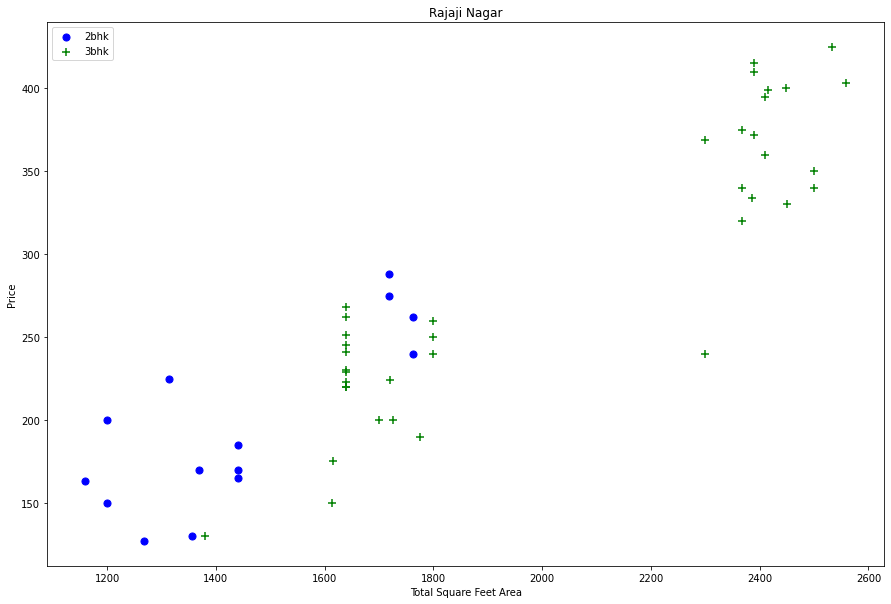

In [404]:
# creating a scatter plot 

def plot_scatter(house_df,location):
    bhk2 = house_df[(house_df.location == location ) & (house_df.bhk == 2)]
    bhk3 = house_df[(house_df.location == location ) & (house_df.bhk == 3)]

    matplotlib.rcParams["figure.figsize"] = (15,10)

    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2bhk', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3bhk', s=50)

    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")

    plt.title(location)
    plt.legend()

plot_scatter(house_df_outlremov,"Rajaji Nagar")

We can observe that for 1700 sqft the 2bhk have high price compared to 3bhk houses.

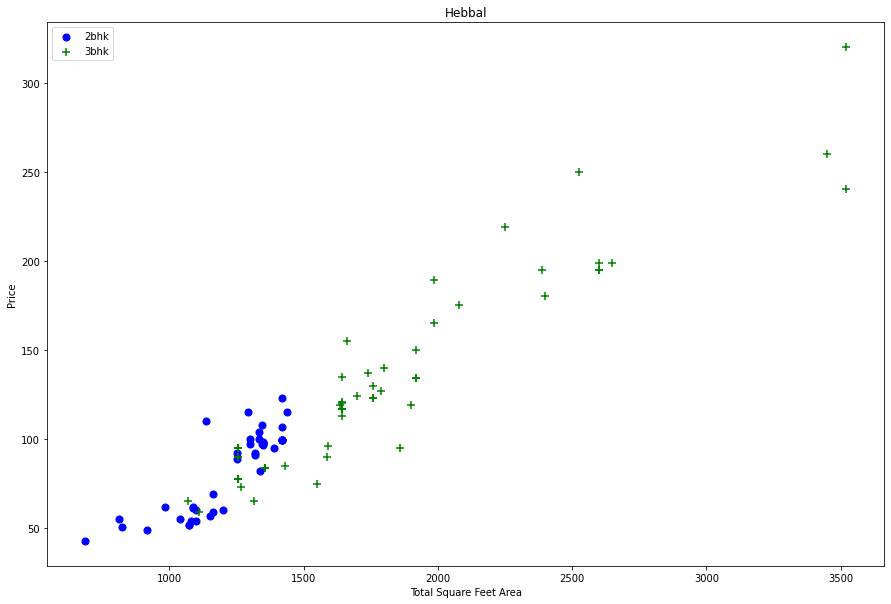

In [405]:
# Check for other location 'Hebbal'

plot_scatter(house_df_outlremov,"Hebbal")

Here also we can observe that for 1300 sqft the 2bhk have high price compared to 3bhk houses.

In [406]:
# Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

def remove_bhk_outliers(house_df):
    exclude_indices = np.array([])
    for location, location_df in house_df.groupby('location'):
        bhk_stats = {}

        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }

        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return house_df.drop(exclude_indices,axis='index')
house_df_2bhk = remove_bhk_outliers(house_df_outlremov)
house_df_2bhk.shape

(7329, 7)

Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

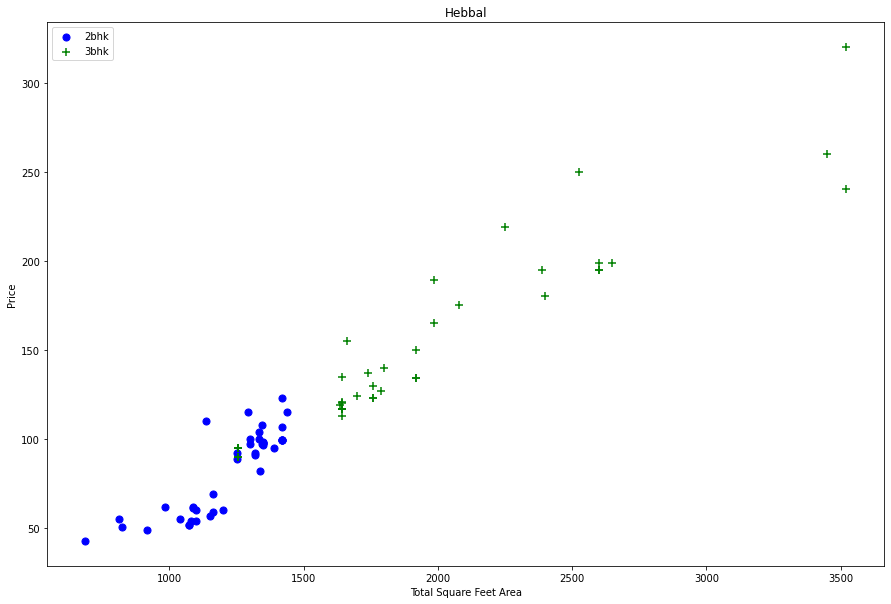

In [407]:
plot_scatter(house_df_2bhk,"Hebbal")

Now we can observe that majority of the 2bhk have low price compared to 3bhk houses.

Plotting a histogram to check the number of houses per square foot area.

Text(0, 0.5, 'Count')

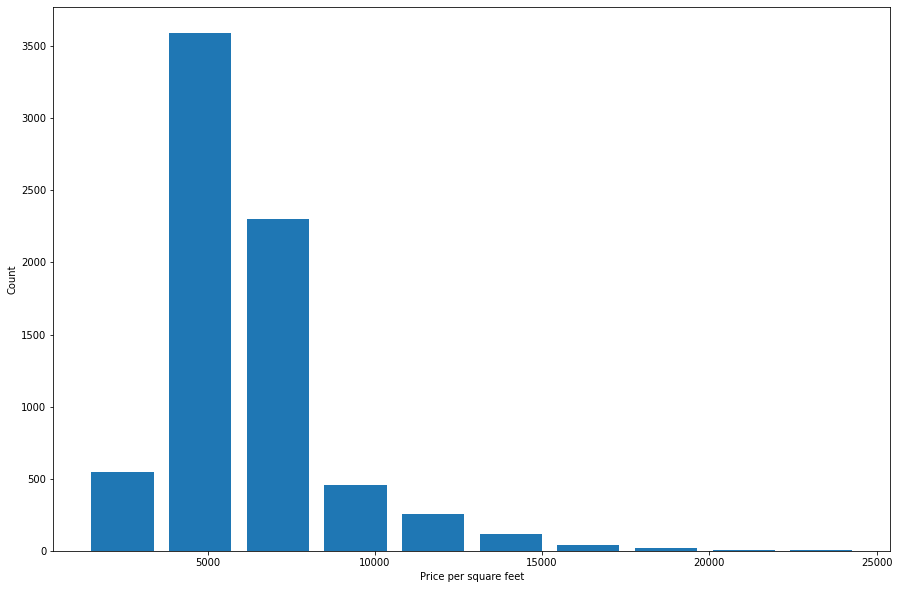

In [408]:
plt.hist(house_df_2bhk.price_per_sqft, rwidth=0.8)
plt.xlabel("Price per square feet")
plt.ylabel("Count")

It is a normal distribution.

The majority of the houses are upto 10000 price per square feet.

In [409]:
# Check for the feature bathroom

house_df_2bhk.bath.unique()


array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

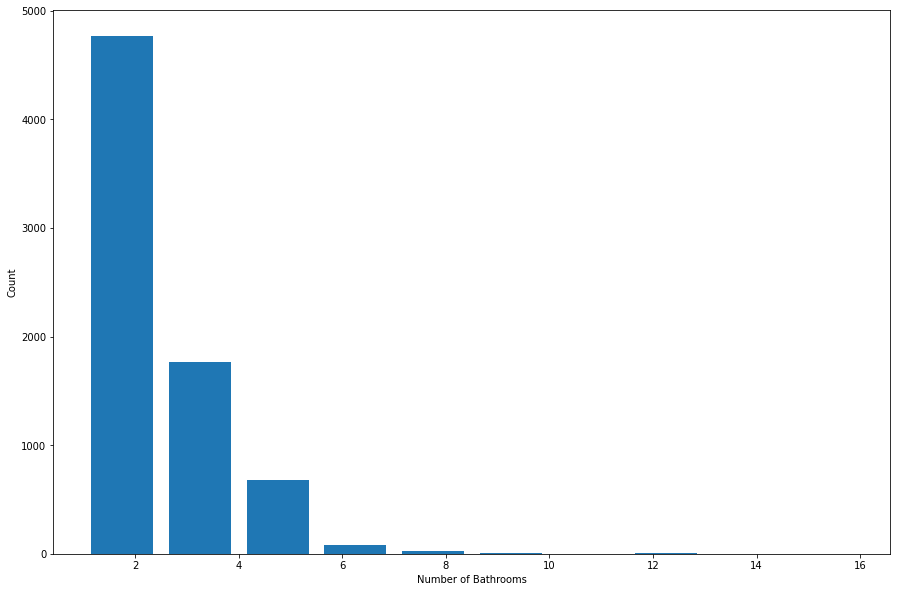

In [410]:
# plotting a histogram

plt.hist(house_df_2bhk.bath,rwidth=0.8)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")

In [411]:
# The number of bathrooms > the number of bedrooms +2 is the outlier we can remove those houses.

house_df_2bhk[house_df_2bhk.bath > house_df_2bhk.bhk+2 ]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


If we have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed.

In [412]:
# removing the outliers in bathroom

house_df_filter = house_df_2bhk[house_df_2bhk.bath < house_df_2bhk.bhk + 2 ]
house_df_filter.shape


(7251, 7)

In [413]:
house_df_filter.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [414]:
# dropping the columns which are not required

house_df_final = house_df_filter.drop(['size','price_per_sqft'],axis='columns')
house_df_final.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


Use One Hot Encoding For Location

In [415]:
house_df_dummies = pd.get_dummies(house_df_final['location'])
house_df_dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [416]:
# combining both the data frames

house_df_final = pd.concat([house_df_final,house_df_dummies.drop('other',axis='columns')],axis='columns')
house_df_final.head(3)

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [417]:
# Now we can drop the location column

house_df_final.drop('location',axis='columns',inplace=True)

In [418]:
house_df_final.head(3)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Build a Model

In [419]:
# shape of the final dataset

house_df_final.shape

(7251, 245)

In [420]:
X = house_df_final.drop('price',axis='columns')
y = house_df_final['price']

In [421]:
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [422]:
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [423]:
from sklearn.model_selection import train_test_split

In [424]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [440]:
# LinearRegression model
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train,y_train)
linear_model.score(X_test,y_test)

0.8243018623639004

Use K Fold cross validation to measure accuracy of our LinearRegression model

In [426]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
score = cross_val_score(linear_model,X,y,cv=cv)
score

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

We are getting a score of 80% in all 5 iterations. 

Find best model using GridSearchCV

In [427]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [428]:
def find_model_using_gridsearchcv(X,y):
    algos = {
        'linear regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True,False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random','cyclic']
            }
        },
        'decision tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse','friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for algo_name,config in algos.items():
        gridsrchcv = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gridsrchcv.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gridsrchcv.best_score_,
            'best_params':gridsrchcv.best_params_
        })

    return pd.DataFrame(scores, columns= ['model', 'best_score', 'best_params' ])

find_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear regression,0.818354,{'normalize': False}
1,lasso,0.687614,"{'alpha': 2, 'selection': 'random'}"
2,decision tree,0.713912,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


Based on the above results we can say that LinearRegression gave us the best score.

Test the model for few properties

In [429]:
# creating a function for predicting the price

def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return linear_model.predict([x])[0] 

In [430]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [431]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

89.83010079821942

In [432]:
predict_price('1st Phase JP Nagar',1000, 2, 3)

88.36729917426003

We can observe that a 3bhk with 2 bathroom is slightly less compared to 2bhk with 2 bathroom. One of the reason might be the rooms may be smaller compared to 2bhk.

In [433]:
predict_price('Indira Nagar',1000, 2, 2)

172.8241298771255

In [434]:
predict_price('Indira Nagar',1000, 3, 3)

176.44407702926594

Export the tested model to a pickle file

In [435]:
import pickle

In [436]:
with open('banglore_home_prices_model.pickle','wb') as f:
     pickle.dump(linear_model,f)

Export location and column information to a file which will be useful in our prediction application

In [437]:
import json

In [438]:
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}

with open("columns.json", "w") as f:
     f.write(json.dumps(columns))